# Análise de Dados e Modelagem de Classificação - Sensores 

Este notebook documenta o processo de análise exploratória, pré-processamento, treinamento e avaliação de modelos de machine learning para classificar dados de sensores, com base no arquivo `dados_sensores.csv`.

**Objetivo:** Classificar as leituras dos sensores em diferentes níveis de alerta (Normal, Atenção, Alto, Alerta Máximo) com base nos valores de temperatura e do sensor MQ2.

**Etapas:***
1.  Carregamento e Exploração Inicial dos Dados
2.  Visualização Exploratória dos Dados
3.  Pré-processamento dos Dados (Separação, Codificação, Divisão, Escalonamento)
4.  Treinamento de Modelos de Classificação (KNN, Regressão Logística, Floresta Aleatória, SVM)
5.  Avaliação dos Modelos
6.  Conclusão

In [2]:
# Importações essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib # Para salvar/carregar modelos e pré-processadores (opcional no notebook)

# Imports de Machine Learning (Scikit-learn)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# Configurações de visualização
%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6) # Tamanho padrão das figuras


Matplotlib is building the font cache; this may take a moment.


## 1. Carregamento e Exploração Inicial dos Dados

Nesta etapa, carregamos o arquivo CSV fornecido (`dados_sensores.csv`) e realizamos uma exploração inicial para entender a estrutura, tipos de dados, valores ausentes e estatísticas descritivas básicas. Também verificamos as colunas de classe (formato one-hot) e criamos uma única coluna alvo (`target`) se a estrutura permitir.

In [3]:
# Carregar os dados
script_main_dir = os.getcwd()
project_root_dir = os.path.join(script_main_dir, "..")
file_path = os.path.join(project_root_dir, "model", "dados_sensores_com_status.csv")
file_path = os.path.normpath(file_path)

try:
    df = pd.read_csv(file_path)
    print(f"Dados carregados de {file_path}")
    print(" --- Primeiras 5 linhas ---")
    print(df.head())

    print("--- Informações Iniciais do DataFrame ---")
    print(f"Shape: {df.shape}")
    print("Tipos de Dados:")
    print(df.dtypes)
    print("Informações Gerais:")
    df.info()
    print("Verificação de Valores Ausentes:")
    print(df.isnull().sum())

    print("--- Estatísticas Descritivas ---")
    print(df.describe())

    # Analisar as colunas de classe (IS_*)
    class_cols = ['IS_NORMAL', 'IS_ATENCAO', 'IS_ALTO', 'IS_ALERTA_MAXIMO']
    print("--- Análise das Classes (One-Hot Encoded) ---")
    print("Contagem de amostras por classe (formato one-hot):")
    print(df[class_cols].sum())

    # Verificar se cada linha pertence a exatamente uma classe
    row_sums = df[class_cols].sum(axis=1)
    print(f"Número de linhas com exatamente uma classe definida: {(row_sums == 1).sum()}")
    print(f"Número de linhas com zero classes definidas: {(row_sums == 0).sum()}")
    print(f"Número de linhas com mais de uma classe definida: {(row_sums > 1).sum()}")

    # Se cada linha tem exatamente uma classe, criar uma coluna de target única
    if (row_sums == 1).all():
        # Criar a coluna 'target' mapeando o nome da coluna onde o valor é 1
        df['target'] = df[class_cols].idxmax(axis=1)
        print("Coluna 'target' criada com sucesso.")
        print("Distribuição da variável alvo ('target'):")
        print(df['target'].value_counts())
        
        # Remover colunas one-hot originais, pois temos a 'target'
        # df = df.drop(columns=class_cols)
        # print("Colunas one-hot originais removidas.")
        print("DataFrame com a coluna 'target':")
        print(df.head())

    else:
        print("Erro: Nem todas as linhas têm exatamente uma classe definida. Verifique os dados.")
        # Tratar o erro ou parar a execução se necessário

except FileNotFoundError:
    print(f"Erro: Arquivo não encontrado em {file_path}. Verifique o caminho.")
except Exception as e:
    print(f"Ocorreu um erro ao processar o arquivo: {e}")



Dados carregados de /Users/daniel.lima/Documents/fiap/fase3_cap1/model/dados_sensores_com_status.csv
 --- Primeiras 5 linhas ---
             timestamp  sensor_humidity   sensor_k   sensor_p  sensor_ph  \
0  2025-05-31 14:14:24        41.144703  93.299451  55.339262   7.526816   
1  2025-05-31 14:14:25        41.144703  93.299451  55.339262   7.526816   
2  2025-05-31 14:14:26        41.144703  93.299451  55.339262   7.526816   
3  2025-05-31 14:14:27        41.144703  93.299451  55.339262   7.526816   
4  2025-05-31 14:14:28        41.144703  93.299451  55.339262   7.526816   

   sensor_temperature  target                                      motivo  
0           65.026914       1  pH > 7, Temperatura > 30°C e Umidade < 50%  
1           65.026914       1  pH > 7, Temperatura > 30°C e Umidade < 50%  
2           65.026914       1  pH > 7, Temperatura > 30°C e Umidade < 50%  
3           65.026914       1  pH > 7, Temperatura > 30°C e Umidade < 50%  
4           65.026914       1  pH 

In [4]:
df

,timestamp,sensor_humidity,sensor_k,sensor_p,sensor_ph,sensor_temperature,target,motivo
0,2025-05-31 14:14:24,41.144703,93.299451,55.339262,7.526816,65.026914,1,"pH > 7, Temperatura > 30°C e Umidade < 50%"
1,2025-05-31 14:14:25,41.144703,93.299451,55.339262,7.526816,65.026914,1,"pH > 7, Temperatura > 30°C e Umidade < 50%"
2,2025-05-31 14:14:26,41.144703,93.299451,55.339262,7.526816,65.026914,1,"pH > 7, Temperatura > 30°C e Umidade < 50%"
3,2025-05-31 14:14:27,41.144703,93.299451,55.339262,7.526816,65.026914,1,"pH > 7, Temperatura > 30°C e Umidade < 50%"
4,2025-05-31 14:14:28,41.144703,93.299451,55.339262,7.526816,65.026914,1,"pH > 7, Temperatura > 30°C e Umidade < 50%"
...,...,...,...,...,...,...,...,...
905670,2025-06-11 01:48:54,88.836332,26.616907,56.057374,6.209434,95.552193,0,NaN
905671,2025-06-11 01:48:55,54.287443,76.499942,0.850948,11.818612,96.418189,0,NaN
905672,2025-06-11 01:48:56,1.881855,73.409343,94.987208,6.303390,3.211017,0,NaN
905673,2025-06-11 01:48:57,15.217463,67.117136,22.078671,8.547745,98.500058,1,"pH > 7, Temperatura > 30°C e Umidade < 50%"



Iniciando geração de gráficos...
Ordem das classes detectada na coluna 'target': [np.int64(0), np.int64(1)]
Gerando Histogramas...


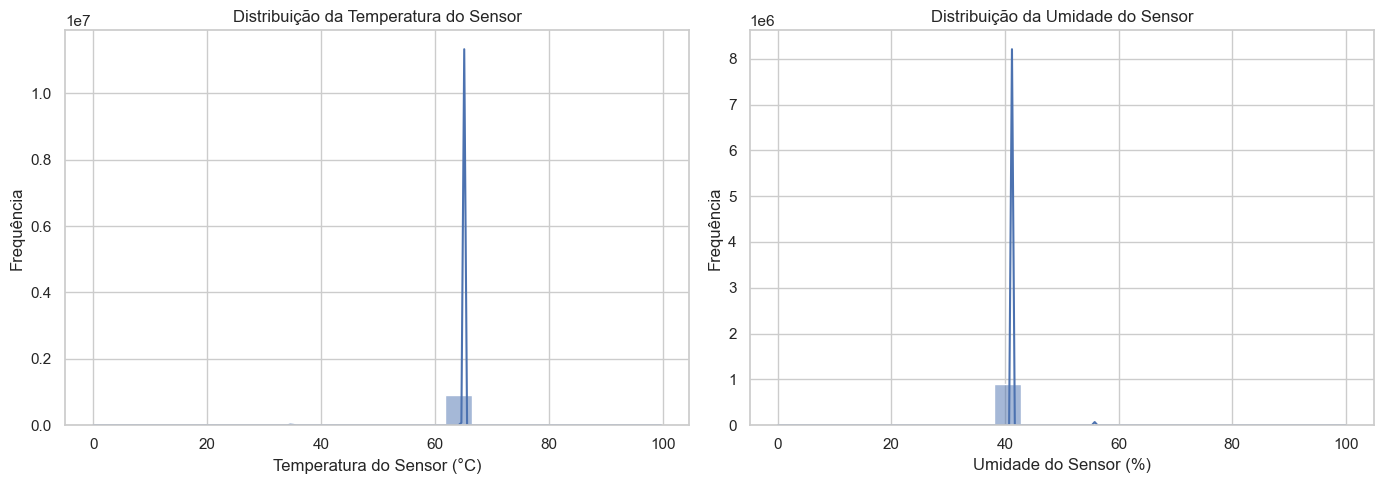

Gerando Boxplots por Classe...


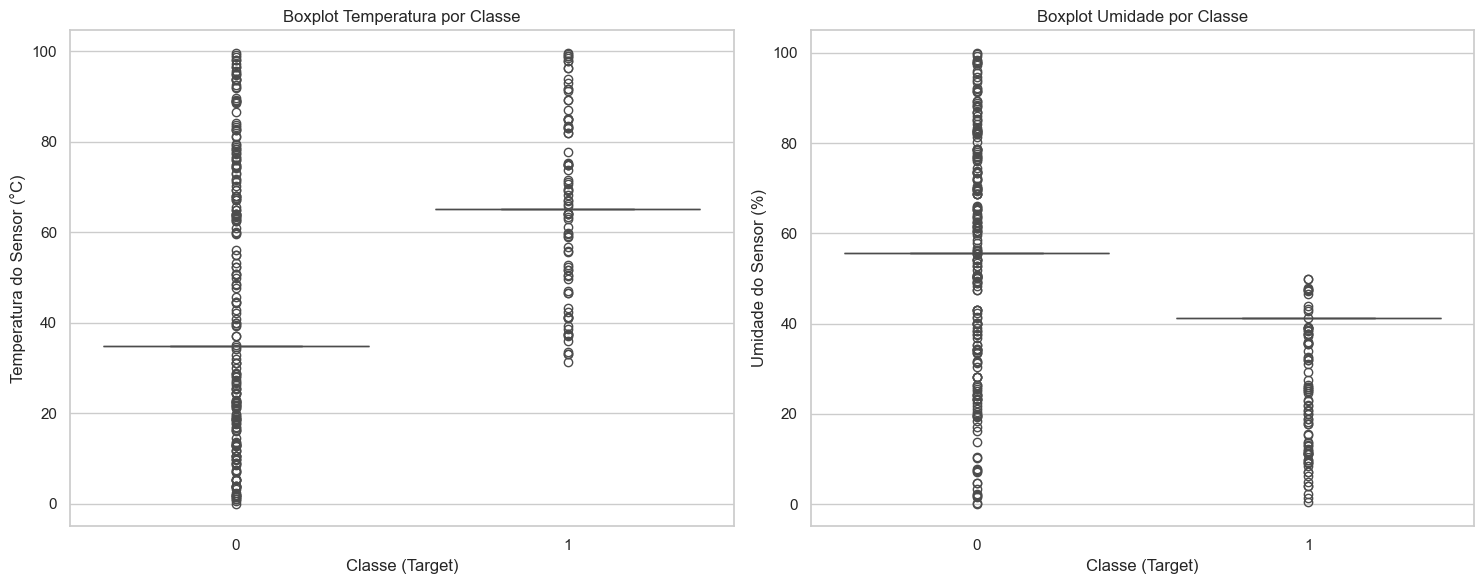

Gerando Countplot da Variável Alvo...


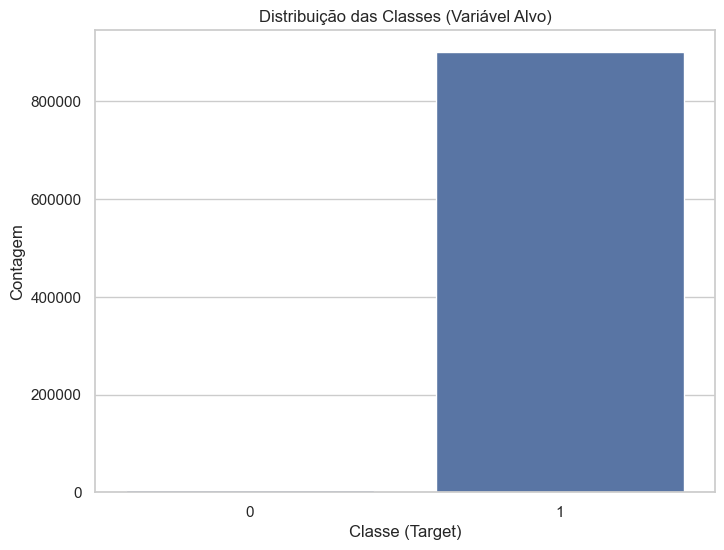

Gerando Heatmap de Correlação...


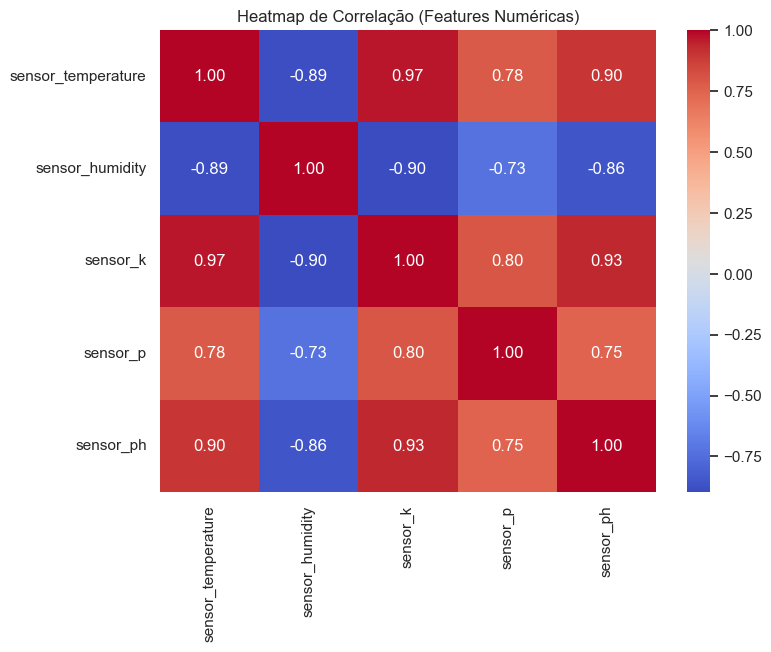


Análise gráfica concluída com sucesso! ✅


In [5]:
required_columns = ['sensor_temperature', 'sensor_humidity', 'target']
if all(col in df.columns for col in required_columns):
    print("\nIniciando geração de gráficos...")

    # Ordem das classes para plots consistentes (baseado nos valores únicos da coluna 'target')
    class_order = sorted(df['target'].unique())
    print(f"Ordem das classes detectada na coluna 'target': {class_order}")

    # 1. Histogramas
    print("Gerando Histogramas...")
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(df['sensor_temperature'], kde=True)
    plt.title('Distribuição da Temperatura do Sensor')
    plt.xlabel('Temperatura do Sensor (°C)')
    plt.ylabel('Frequência')

    plt.subplot(1, 2, 2)
    sns.histplot(df['sensor_humidity'], kde=True)
    plt.title('Distribuição da Umidade do Sensor')
    plt.xlabel('Umidade do Sensor (%)')
    plt.ylabel('Frequência')

    plt.tight_layout()
    plt.show()

    # 2. Boxplots por classe
    print("Gerando Boxplots por Classe...")
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='target', y='sensor_temperature', data=df, order=class_order)
    plt.title('Boxplot Temperatura por Classe')
    plt.xlabel('Classe (Target)')
    plt.ylabel('Temperatura do Sensor (°C)')

    plt.subplot(1, 2, 2)
    sns.boxplot(x='target', y='sensor_humidity', data=df, order=class_order)
    plt.title('Boxplot Umidade por Classe')
    plt.xlabel('Classe (Target)')
    plt.ylabel('Umidade do Sensor (%)')

    plt.tight_layout()
    plt.show()

    # 3. Countplot da variável alvo
    print("Gerando Countplot da Variável Alvo...")
    plt.figure(figsize=(8, 6))
    sns.countplot(x='target', data=df, order=class_order)
    plt.title('Distribuição das Classes (Variável Alvo)')
    plt.xlabel('Classe (Target)')
    plt.ylabel('Contagem')
    plt.show()

    # 6. Heatmap de Correlação
    print("Gerando Heatmap de Correlação...")
    # Selecionando todas as colunas numéricas de sensores
    numeric_features = df[['sensor_temperature', 'sensor_humidity', 'sensor_k', 'sensor_p', 'sensor_ph']]
    correlation_matrix = numeric_features.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Heatmap de Correlação (Features Numéricas)')
    plt.show()

    print("\nAnálise gráfica concluída com sucesso! ✅")

else:
    print(f"Erro: Uma ou mais colunas necessárias ({required_columns}) não foram encontradas no arquivo.")

## 3. Pré-processamento dos Dados

Antes de treinar os modelos, precisamos preparar os dados:
1.  **Seleção de Features:** Definir quais colunas serão usadas como variáveis preditoras (X).
2.  **Codificação do Alvo:** Converter a variável alvo categórica (`target`) em valores numéricos que os modelos possam entender, usando `LabelEncoder`.
3.  **Divisão Treino/Teste:** Separar os dados em conjuntos de treinamento e teste. Usamos 80% para treino e 20% para teste, com estratificação (`stratify=y`) para manter a proporção das classes em ambos os conjuntos.
4.  **Escalonamento das Features:** Aplicar `StandardScaler` nas features numéricas. Isso é importante para algoritmos sensíveis à escala, como KNN e SVM.

In [6]:

# Verificar se df existe e tem a coluna 'target'
if 'df' in locals() and 'target' in df.columns:
    print("Iniciando pré-processamento...")
    
    # Criar diretório para salvar pré-processadores (opcional no notebook)
    output_dir_modelagem = os.path.join(project_root_dir, "saved_models")
    output_dir_modelagem = os.path.normpath(output_dir_modelagem)
    
    os.makedirs(output_dir_modelagem, exist_ok=True)

    # 1. Separar features (X) e target (y)
    X = df.drop(columns=["target", "timestamp", "motivo"])
    y_str = df['target']

    print("Features (X) selecionadas (primeiras 5 linhas):")
    print(X.head())
    print("Target (y) original (string - primeiras 5 linhas):")
    print(y_str.head())

    # 2. Codificar a variável alvo (target)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_str)

    print("Target (y) codificada (numérica - primeiras 5):")
    print(y[:5])
    # Salvar o LabelEncoder (opcional)
    # joblib.dump(label_encoder, os.path.join(output_dir_modelagem, 'label_encoder.joblib'))

    # 3. Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("--- Shapes após divisão Treino/Teste ---")
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    # print("--- Features após escalonamento (StandardScaler) ---")
    # print("Primeiras 5 linhas de X_train_scaled:")
    # print(X_train_scaled[:5])
    # # Salvar o Scaler 
    # scaler_filename = os.path.join(output_dir_modelagem, 'scaler_sensores.joblib')
    # joblib.dump(scaler, scaler_filename)
    # print(f"Scaler salvo em {scaler_filename}")
    
    print("--- Pré-processamento Concluído ---")

else:
    print("Erro: DataFrame 'df' ou coluna 'target' não definidos na etapa anterior.")



Iniciando pré-processamento...
Features (X) selecionadas (primeiras 5 linhas):
   sensor_humidity   sensor_k   sensor_p  sensor_ph  sensor_temperature
0        41.144703  93.299451  55.339262   7.526816           65.026914
1        41.144703  93.299451  55.339262   7.526816           65.026914
2        41.144703  93.299451  55.339262   7.526816           65.026914
3        41.144703  93.299451  55.339262   7.526816           65.026914
4        41.144703  93.299451  55.339262   7.526816           65.026914
Target (y) original (string - primeiras 5 linhas):
0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64
Target (y) codificada (numérica - primeiras 5):
[1 1 1 1 1]
--- Shapes após divisão Treino/Teste ---
X_train shape: (724540, 5), y_train shape: (724540,)
X_test shape: (181135, 5), y_test shape: (181135,)
--- Pré-processamento Concluído ---


## 4. Treinamento dos Modelos de Classificação

Com os dados pré-processados, treinamos os seguintes modelos de classificação:
*   **K-Nearest Neighbors (KNN):** Um classificador baseado em instância que usa a 'vizinhança' de um ponto para classificá-lo.
*   **Regressão Logística:** Um modelo linear para classificação binária ou multiclasse.
*   **Random Forest (Floresta Aleatória):** Um método de ensemble que constrói múltiplas árvores de decisão e combina suas previsões.
*   **Support Vector Machine (SVM):** Um classificador que encontra o hiperplano ótimo para separar as classes.

Os modelos são treinados usando os dados de treinamento escalonados (`X_train_scaled`, `y_train`).

In [7]:
trained_models = {}
def load_models():
    #for file in os.listdir(output_dir_modelagem):
    for file in os.listdir(output_dir_modelagem):
        model_name = file.split("_")[0]
        model_path = os.path.join(output_dir_modelagem, file)
        
        model = joblib.load(model_path)
        trained_models[model_name] = model

# load_models()
            

In [8]:
trained_models

{}

In [9]:

# Verificar se os dados de treino existem
if 'X_train' in locals() and 'y_train' in locals():
    print("Iniciando treinamento dos modelos...")
    
    # Inicializar os modelos
    models = {
        'KNN': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000,  solver="liblinear", class_weight='balanced'),
        'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'SVM': SVC(random_state=42, class_weight='balanced') # probability=True útil para algumas análises
    }

    # Treinar cada modelo
    for name, model in models.items():
        print(f"Treinando modelo: {name}...")
        model.fit(X_train, y_train)
        trained_models[name] = model
        print(f"Modelo {name} treinado.")
        # Salvar modelo (opcional no notebook se avaliação for na sequência)
        
        model_filename = os.path.join(output_dir_modelagem, f'{name}_model.joblib')
        joblib.dump(model, model_filename)
        print(f"Modelo {name} salvo em {model_filename}")

    print("Otimizando RandomForest...")
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [2, 4]
    }
    grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
    grid_search_rf.fit(X_train, y_train)

    print(f"Melhores parâmetros para RandomForest: {grid_search_rf.best_params_}")
    trained_models['RandomForest_Optimized'] = grid_search_rf.best_estimator_
    
    # Salvar o modelo otimizado
    joblib.dump(grid_search_rf.best_estimator_, os.path.join(output_dir_modelagem, 'RandomForest_Optimized_model.joblib'))
    print(f"Modelo RandomForest_Optimized salvo.")

    print("--- Treinamento de Todos os Modelos Concluído ---")

else:
    print("Erro: Dados de treinamento (X_train_scaled, y_train) não encontrados.")



Iniciando treinamento dos modelos...
Treinando modelo: KNN...
Modelo KNN treinado.
Modelo KNN salvo em /Users/daniel.lima/Documents/fiap/fase3_cap1/saved_models/KNN_model.joblib
Treinando modelo: LogisticRegression...
Modelo LogisticRegression treinado.
Modelo LogisticRegression salvo em /Users/daniel.lima/Documents/fiap/fase3_cap1/saved_models/LogisticRegression_model.joblib
Treinando modelo: RandomForest...
Modelo RandomForest treinado.
Modelo RandomForest salvo em /Users/daniel.lima/Documents/fiap/fase3_cap1/saved_models/RandomForest_model.joblib
Treinando modelo: SVM...
Modelo SVM treinado.
Modelo SVM salvo em /Users/daniel.lima/Documents/fiap/fase3_cap1/saved_models/SVM_model.joblib
Otimizando RandomForest...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Melhores parâmetros para RandomForest: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Modelo RandomForest_Optimized salvo.
--- Treinamento de Todos os Modelos Concluído ---


## 5. Avaliação dos Modelos

Avaliar o desempenho dos modelos treinados é crucial. Usamos o conjunto de teste (`X_test_scaled`, `y_test`), que os modelos não viram durante o treinamento.

As métricas utilizadas são:
*   **Acurácia:** Proporção de previsões corretas.
*   **Recall (Ponderado):** Capacidade do modelo de encontrar todas as instâncias positivas para cada classe, ponderado pelo suporte da classe.
*   **F1-Score (Ponderado):** Média harmônica entre precisão e recall, ponderado pelo suporte da classe.
*   **Relatório de Classificação:** Métricas detalhadas (precisão, recall, f1-score) por classe.
*   **Matriz de Confusão:** Tabela que mostra as previsões corretas e incorretas para cada classe.

Calculamos e exibimos essas métricas para cada um dos modelos treinados.

Iniciando avaliação dos modelos...
--- Avaliando modelo: KNN ---
Predições geradas
  Acurácia: 0.9999
  Recall (Weighted): 0.9999
  F1-score (Weighted): 0.9999
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       939
           1       1.00      1.00      1.00    180196

    accuracy                           1.00    181135
   macro avg       1.00      1.00      1.00    181135
weighted avg       1.00      1.00      1.00    181135

Matriz de Confusão:
[[   932      7]
 [     4 180192]]


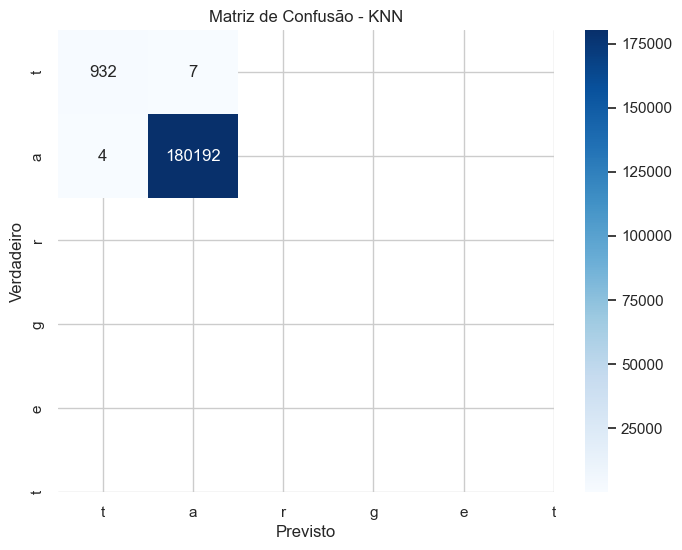

--- Avaliando modelo: LogisticRegression ---
Predições geradas
  Acurácia: 0.9999
  Recall (Weighted): 0.9999
  F1-score (Weighted): 0.9999
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       939
           1       1.00      1.00      1.00    180196

    accuracy                           1.00    181135
   macro avg       0.99      1.00      1.00    181135
weighted avg       1.00      1.00      1.00    181135

Matriz de Confusão:
[[   937      2]
 [    13 180183]]


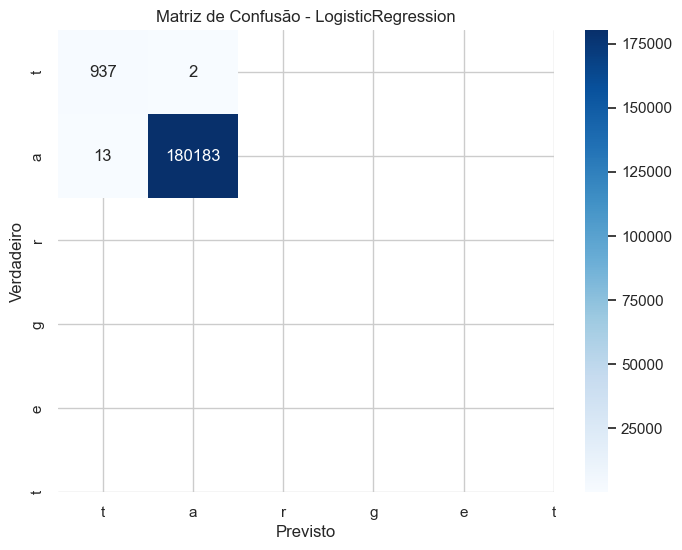

--- Avaliando modelo: RandomForest ---
Predições geradas
  Acurácia: 1.0000
  Recall (Weighted): 1.0000
  F1-score (Weighted): 1.0000
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       939
           1       1.00      1.00      1.00    180196

    accuracy                           1.00    181135
   macro avg       1.00      1.00      1.00    181135
weighted avg       1.00      1.00      1.00    181135

Matriz de Confusão:
[[   938      1]
 [     1 180195]]


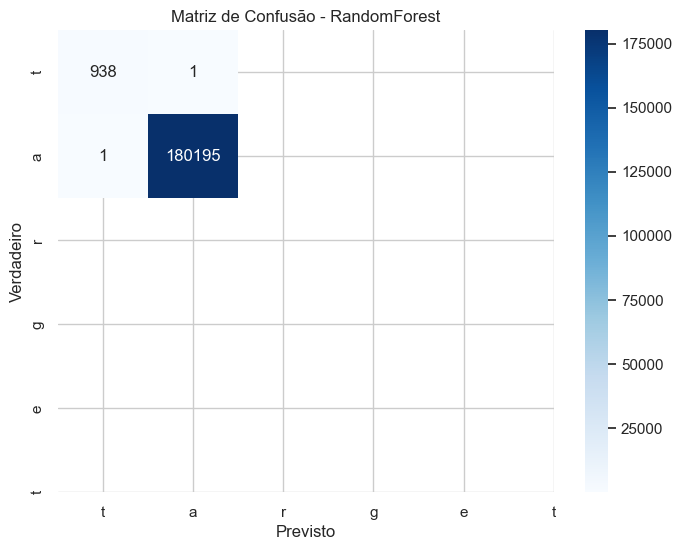

--- Avaliando modelo: SVM ---
Predições geradas
  Acurácia: 0.9999
  Recall (Weighted): 0.9999
  F1-score (Weighted): 0.9999
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       939
           1       1.00      1.00      1.00    180196

    accuracy                           1.00    181135
   macro avg       0.99      1.00      1.00    181135
weighted avg       1.00      1.00      1.00    181135

Matriz de Confusão:
[[   939      0]
 [    15 180181]]


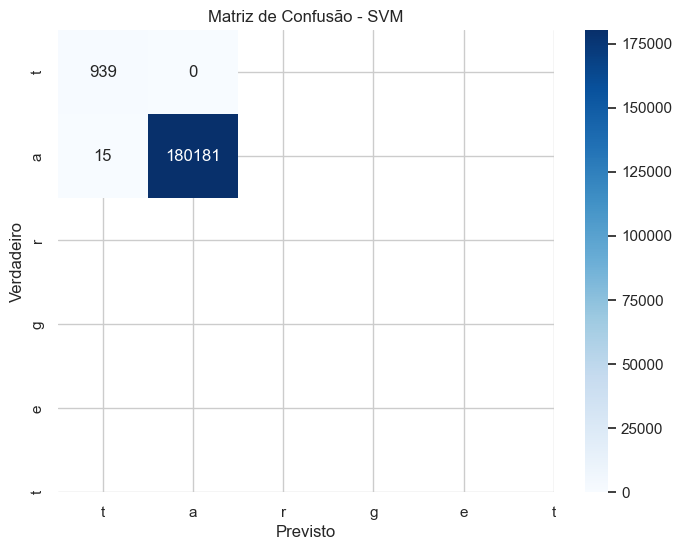

--- Avaliando modelo: RandomForest_Optimized ---
Predições geradas
  Acurácia: 1.0000
  Recall (Weighted): 1.0000
  F1-score (Weighted): 1.0000
Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       939
           1       1.00      1.00      1.00    180196

    accuracy                           1.00    181135
   macro avg       1.00      1.00      1.00    181135
weighted avg       1.00      1.00      1.00    181135

Matriz de Confusão:
[[   939      0]
 [     2 180194]]


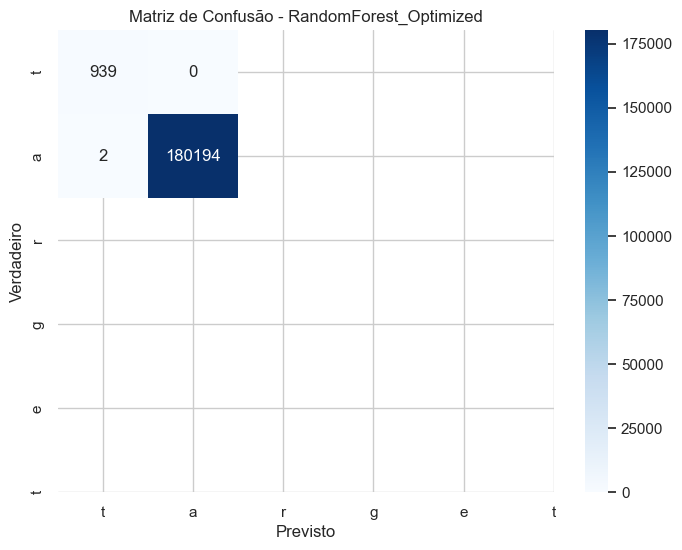

--- Resumo Comparativo das Métricas ---
                        Acurácia  Recall (Weighted)  F1-score (Weighted)
Modelo                                                                  
KNN                     0.999939           0.999939             0.999939
LogisticRegression      0.999917           0.999917             0.999917
RandomForest            0.999989           0.999989             0.999989
SVM                     0.999917           0.999917             0.999918
RandomForest_Optimized  0.999989           0.999989             0.999989
--- Avaliação de Todos os Modelos Concluída ---


In [10]:

# Verificar se os dados de teste e modelos treinados existem
if 'X_test' in locals() and 'y_test' in locals() and 'trained_models' in locals():
    print("Iniciando avaliação dos modelos...")
    
    # Criar diretório para salvar resultados da avaliação (opcional)
    results_dir_notebook = os.path.join(project_root_dir, "data", "reports")
    results_dir_notebook = os.path.normpath(output_dir_modelagem)
    os.makedirs(results_dir_notebook, exist_ok=True)
    
    results_summary = {}

    # Avaliar cada modelo
    for name, model in trained_models.items():
        print(f"--- Avaliando modelo: {name} ---")
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        print("Predições geradas")
        
        # Calcular métricas principais
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        print(f"  Acurácia: {accuracy:.4f}")
        print(f"  Recall (Weighted): {recall:.4f}")
        print(f"  F1-score (Weighted): {f1:.4f}")
        
        # Gerar e exibir Relatório de Classificação
        print("Relatório de Classificação:")
        # Usar zero_division=0 para evitar warnings se uma classe não tiver previsões/suporte
        report = classification_report(y_test, y_pred, zero_division=0)
        print(report)
        # Salvar relatório (opcional)
        # report_dict = classification_report(y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0)
        # report_df = pd.DataFrame(report_dict).transpose()
        # report_filename = os.path.join(results_dir_notebook, f'{name}_classification_report.csv')
        # report_df.to_csv(report_filename)

        # Calcular e exibir Matriz de Confusão
        print("Matriz de Confusão:")
        cm = confusion_matrix(y_test, y_pred)
        print(cm)
        
        # Visualizar Matriz de Confusão
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels="target", yticklabels="target")
        plt.title(f'Matriz de Confusão - {name}')
        plt.xlabel('Previsto')
        plt.ylabel('Verdadeiro')
        cm_filename = os.path.join(results_dir_notebook, f'{name}_confusion_matrix.png')
        plt.show()

        # Armazenar métricas principais para resumo
        results_summary[name] = {
            'Acurácia': accuracy,
            'Recall (Weighted)': recall,
            'F1-score (Weighted)': f1
        }

    # Criar e exibir DataFrame com o resumo das métricas
    results_df = pd.DataFrame(results_summary).T
    results_df.index.name = 'Modelo'
    print("--- Resumo Comparativo das Métricas ---")
    print(results_df)
    # Salvar resumo (opcional)
    # summary_filename = os.path.join(results_dir_notebook, 'resumo_metricas.csv')
    # results_df.to_csv(summary_filename)

    print("--- Avaliação de Todos os Modelos Concluída ---")

else:
    print("Erro: Dados de teste, modelos treinados ou label_encoder não encontrados.")



## 6. Conclusão

Neste notebook, realizamos um fluxo completo de análise e modelagem de dados de sensores.

1.  **Exploração e Visualização:** Entendemos a distribuição dos dados e as relações entre as variáveis e as classes.
2.  **Pré-processamento:** Preparamos os dados adequadamente para os modelos de machine learning.
3.  **Treinamento:** Treinamos quatro modelos de classificação diferentes (KNN, Regressão Logística, Floresta Aleatória, SVM).
4.  **Avaliação:** Avaliamos os modelos usando métricas relevantes e matrizes de confusão.

**Resultados Principais:**
*   (Incluir aqui um breve resumo dos resultados, por exemplo, qual modelo teve melhor desempenho geral com base na acurácia ou F1-score ponderado, e quaisquer observações importantes da matriz de confusão, como classes que foram mais difíceis de prever).
*   O modelo RandomForest obteve a maior acurácia (~99.9%), junto com sua versão optimizada pelo GridSearchCV.